## Finetuning a BERT-base binary classifer 


* Objective: predict if a sentence is grammatically acceptable
* Data source: The Corpus of Linguistic Acceptability https://nyu-mll.github.io/CoLA/ 

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [12]:
# load data and labels on grammatically incorrect sentences:http://nyu-mll.github.io/cola
df = pd.read_csv(
    "./cola_public/raw/in_domain_train.tsv",
    sep="\t",
    header=None,
    usecols=[1, 3],
    names=["labels", "sentence"],
)

# reduce dataframe size to 3000 balanced samples
df = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(1500, random_state=42))

# split train/test data and save a copy locally for future references
train_df, test_df = train_test_split(df)
train_df.to_csv("./data/train.csv", index=False)
test_df.to_csv("./data/test.csv", index=False)

C:\Users\Valerio Pellicciari\AppData\Local\Temp\ipykernel_26696\3374521076.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(1500, random_state=42))


In [13]:
# select tokenizer (bert-base-cased)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# deine tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# convert sentence and labels to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# execute tokenization of train, test data
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# drop leftover columns from pandas initiations
tokenized_train = tokenized_train.remove_columns(["sentence", "__index_level_0__"])
tokenized_test  = tokenized_test.remove_columns(["sentence", "__index_level_0__"])

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [14]:
# prep data loader
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")    # helps arrange samples into batches
train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True, collate_fn=collator, num_workers=0)    # feed data in shuffled batches to model
eval_loader  = DataLoader(tokenized_test,  batch_size=32, shuffle=False, collate_fn=collator, num_workers=0)   # feed data in shuffled batches to model

In [15]:
# import bert_base model. Add a FCNN head for binary classification.
def create_model():
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

    # replace the classifier with your custom head
    hidden_size = model.config.hidden_size  # 768 for bert-base
    model.classifier = nn.Sequential(
        nn.Linear(hidden_size, 128),
        nn.ReLU(),
        nn.Linear(128, model.config.num_labels),
        nn.LogSoftmax(dim=1)
    )
    
    return model

model = create_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# define optimizer. Use different learning rates for backbone/head.
head_params = (p for p in model.parameters() if p.requires_grad)
optimizer = torch.optim.AdamW([
    {"params": model.bert.parameters(), "lr": 2e-5},
    {"params": model.classifier.parameters(), "lr": 1e-3},
], weight_decay=1e-2)

# define cost functions
cost = nn.NLLLoss()            

In [17]:
# trainng loop for bert_base model
def train(model, train_loader, optimizer, epochs, device='cpu'):
    model=model.to(device)                      # Ensure the model is on the correct device

    for epoch in range(1, epochs + 1):          
        model.train()                                       # Set model in training model
        # reset tracking variables
        running_loss = 0                # sum of all batch losses in epoch
        correct = 0                     # number of correctly classified samples
        total = 0                       # total number of samples seen

        # loop through each batch
        for step, batch in enumerate(train_loader):
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True).long()
            ttids     = batch.get("token_type_ids")
            ttids     = ttids.to(device, non_blocking=True) if ttids is not None else None

            # training step
            model.zero_grad()                                           # resets gradient for new batch
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention,
                token_type_ids=ttids)
            log_probs = outputs.logits            # this is LogSoftmax output
            loss = cost(log_probs, labels)
            running_loss += loss.item()                                   # cumulative loss
            loss.backward()                                             # calculates backpropagation gradient for model params
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # gradient clipping
            optimizer.step()                                            # updates weights and biases

            # accuracy calculations
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # print stmt every 50 steps
            if step % 50  == 0:                                         
                seen = (step + 1) * input_ids.size(0)
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}".format(
                        epoch,
                        seen,
                        total,
                        100.0 * (step + 1) / len(train_loader),
                        loss.item(),
                    )
                )
            
        # Epoch summary
        avg_loss = running_loss / len(train_loader)     # Average loss per batch
        avg_accuracy = 100 * correct / total            # Average accuracy per batch
        print(f'Epoch {epoch}: Loss {avg_loss:.4f}, Accuracy {avg_accuracy:.2f}%')

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on Device {device}")
train(model, train_loader, optimizer, epochs=2, device=device)

Running on Device cuda:0
Train Epoch: 1 [16/16 (1%)] Loss: 0.673737
Train Epoch: 1 [816/816 (36%)] Loss: 0.590855
Train Epoch: 1 [1616/1616 (72%)] Loss: 0.438345
Epoch 1: Loss 0.6405, Accuracy 63.47%
Train Epoch: 2 [16/16 (1%)] Loss: 0.395884
Train Epoch: 2 [816/816 (36%)] Loss: 0.547392
Train Epoch: 2 [1616/1616 (72%)] Loss: 0.224357
Epoch 2: Loss 0.3735, Accuracy 84.89%


In [18]:
# test loop for bert_base model
def test(model, eval_loader, device='cpu'):
    model.eval()            # Set the model to evaluation mode
    model.to(device)        # Ensure the model is on the correct device

    # tracking variables
    correct = 0     
    all_preds = []
    all_labels = []
    
    # No gradients are needed for the evaluation
    with torch.no_grad():                           

        # iterate through all batches in test data
        for batch in eval_loader:

            # prediction step 
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True).long()
            ttids     = batch.get("token_type_ids")
            ttids     = ttids.to(device, non_blocking=True) if ttids is not None else None

            # training step
            outputs = model(input_ids=input_ids,
                            attention_mask=attention,
                            token_type_ids=ttids,
                            labels=labels)
            
            # accuracy calculations
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()

            # save for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # final accuracy calculation for all batches
    test_accuracy = 100 * correct / len(eval_loader.dataset)
    print(f'Test set: Accuracy: {correct}/{len(eval_loader.dataset)} ({test_accuracy:.2f}%)')

    return all_preds, all_labels

preds, labels = test(model, eval_loader, device=device)

Test set: Accuracy: 555/750 (74.00%)


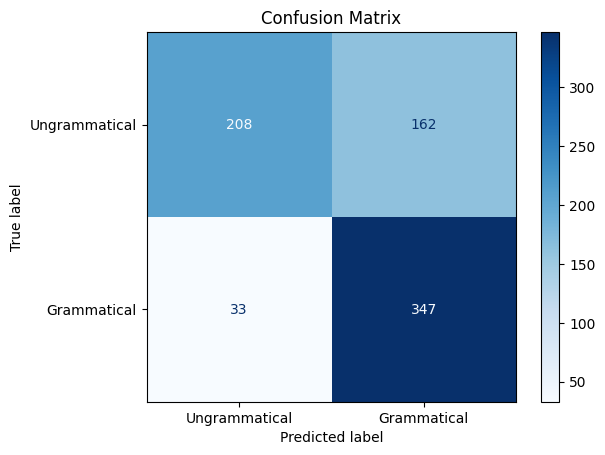

In [19]:
# display confusion matrix for classification results
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ungrammatical", "Grammatical"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()